In [ ]:
# %pip install pandas
# %pip install matplotlib
# %pip install seaborn
# %pip install scikit-learn

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import copy

## Sprint 1 – action classification through key points

Workflow:
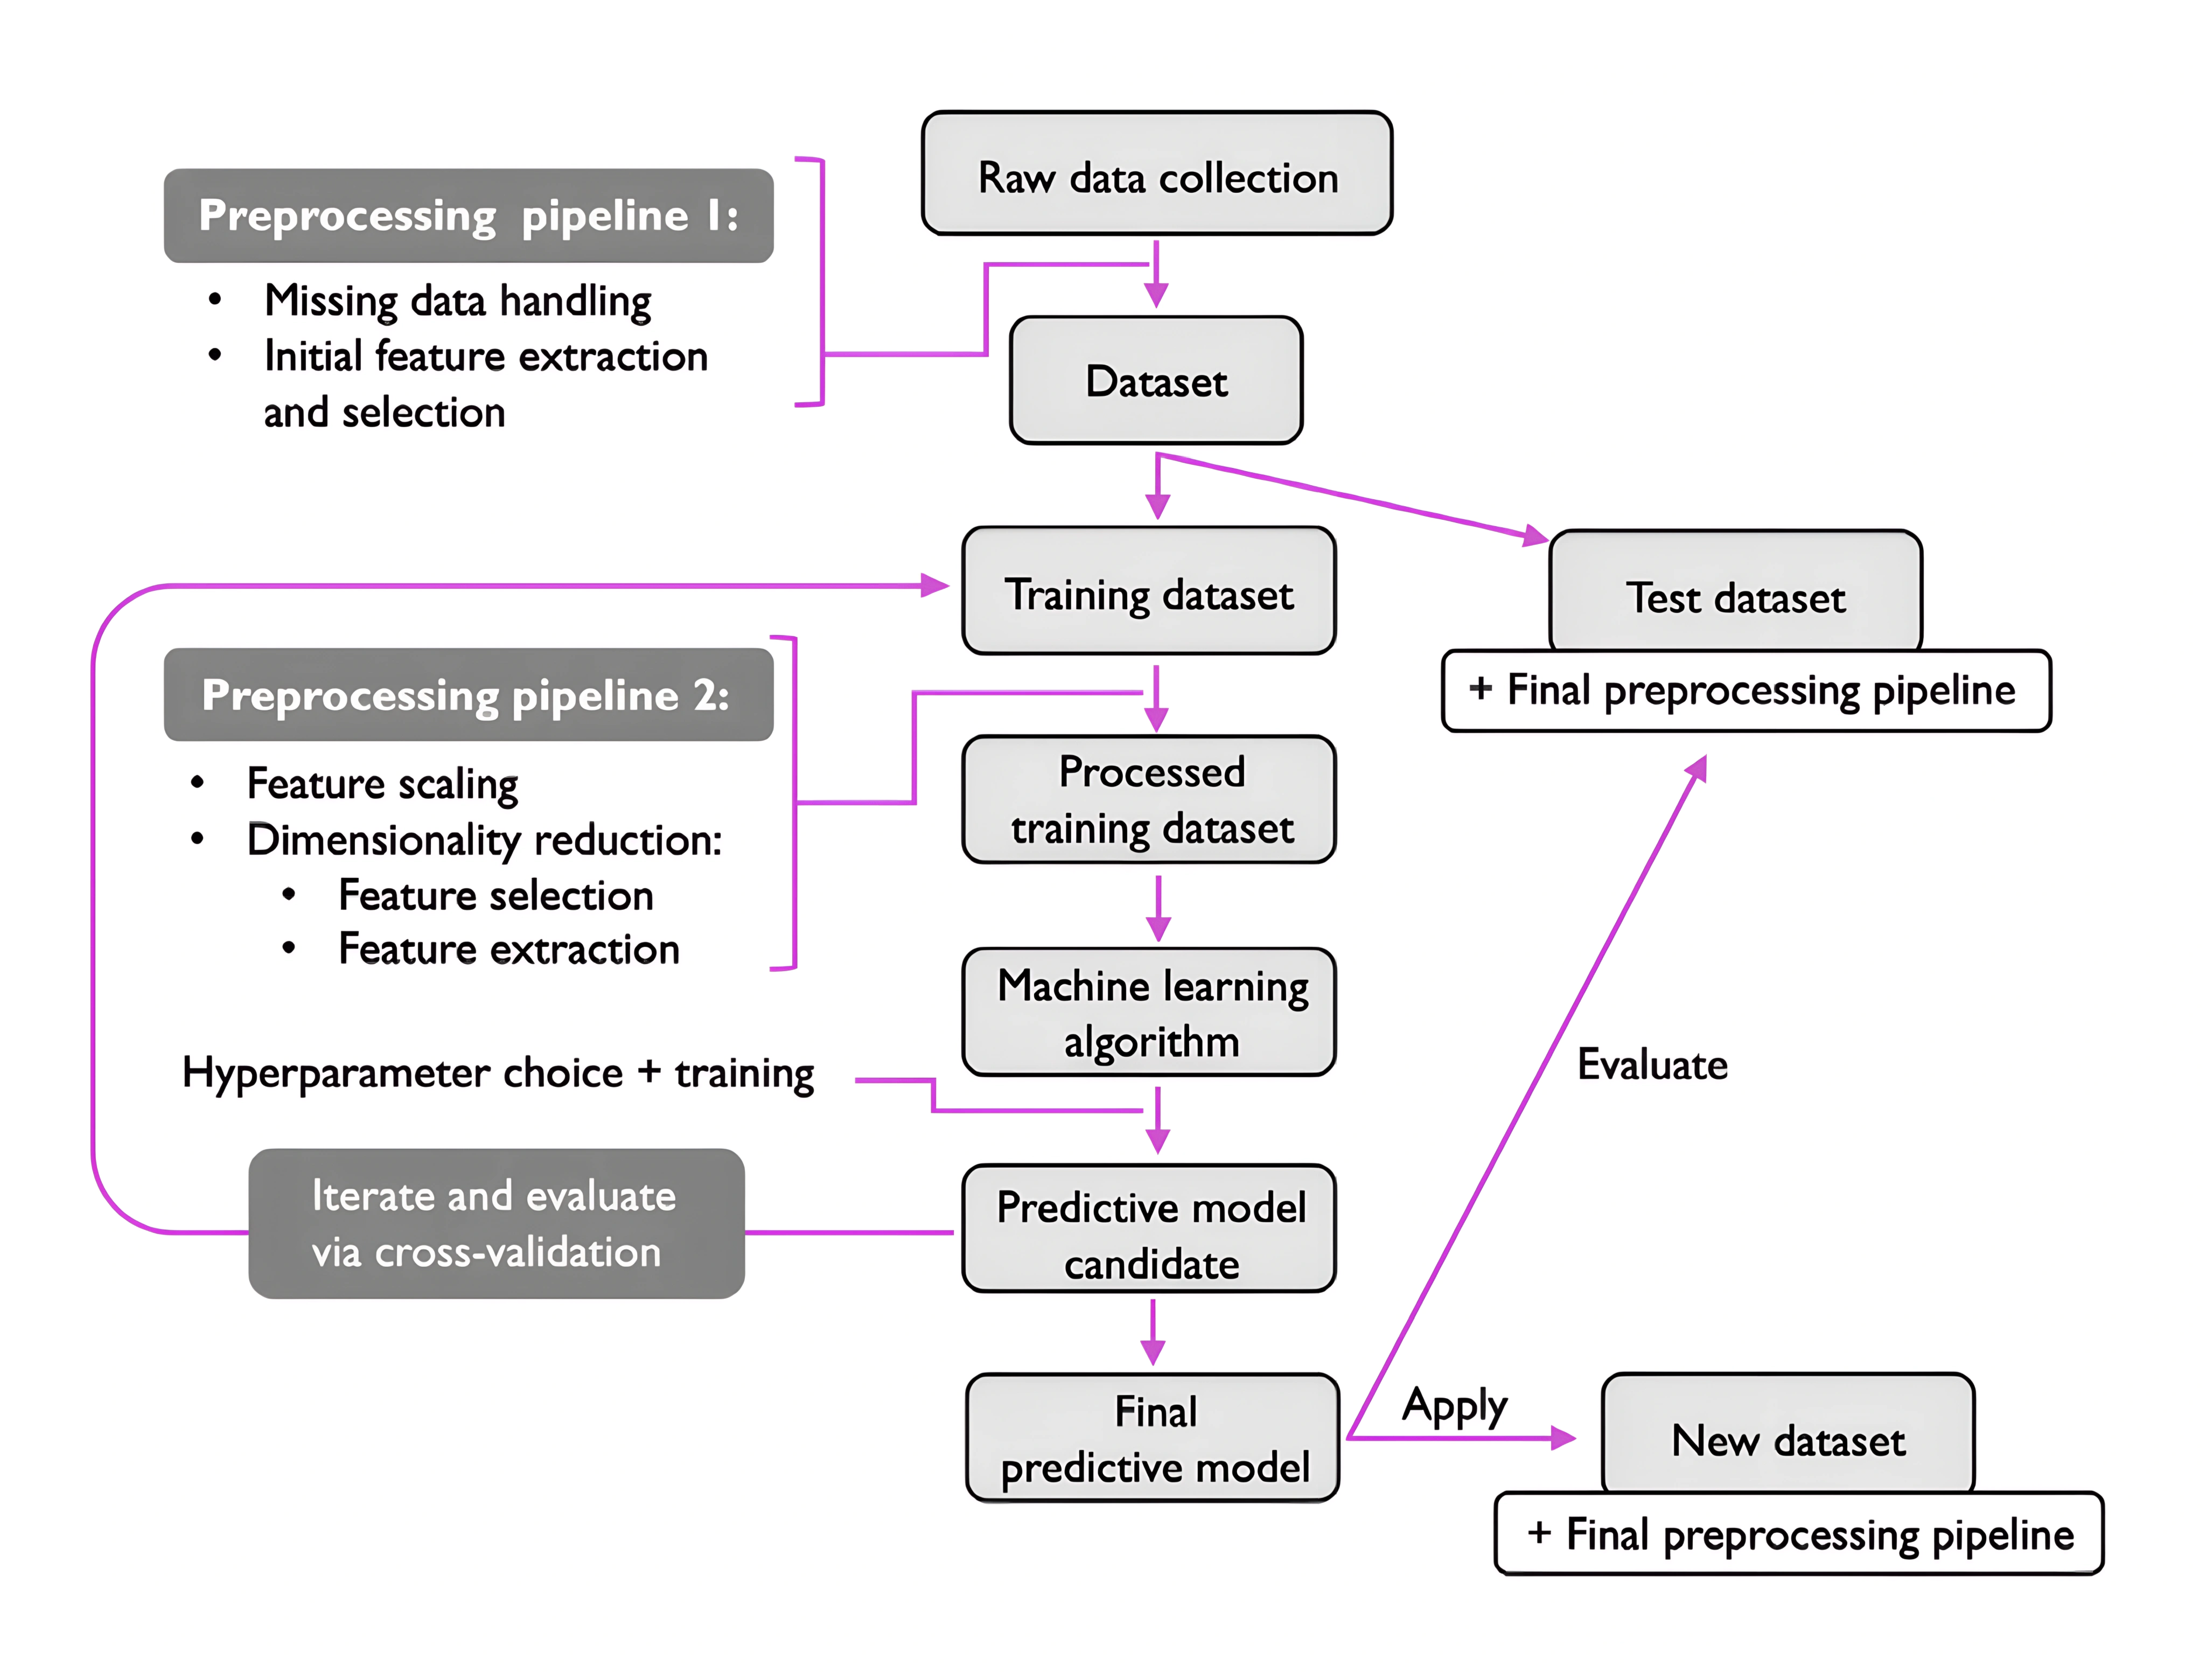

## Helper functions

In [ ]:
def filter_files_by_action(action_number,files):
    return [file for file in files if f'action-{action_number}' in file]


# NOT USED
def filter_files_by_group(group_number,files):
    return [file for file in files if f'group-{group_number}' in file]

## Exploratory data analysis


The data file names consist of the action that was performed by which group it was performed and the recording so which student of that group. The same number does not always refer to the same student of a certain group! To filter data by action simply look at the number after action-x. When you look at this you can filter what acction you want to use. If you want to filter by group you can do the same thing but with group-x. The dataset is very balanced, because every action has been performed by each student in each group. And all recordings are 450 frames. This means that we have equal amounts of data for each action and from each student. 

In [ ]:
data_dir = '../actions'
files = [file for file in os.listdir(data_dir) if file.endswith('.npy') and not file.startswith('._')]

In [ ]:
def load_data(file_list):
    data = []
    for file in file_list:
        file_path = os.path.join(data_dir, file)
        try:
            data.append(np.load(file_path, allow_pickle=True))
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    return np.concatenate(data, axis=0) if data else np.array([])

In [ ]:
data = load_data(files)
print(data.shape)

In [ ]:
def check_balance(files):
    action_counts = {}
    for file in files:
        action_number = int(file.split('-')[1].split('-')[0])
        if action_number not in action_counts:
            action_counts[action_number] = 0
        action_counts[action_number] += 1
    return action_counts

balance = check_balance(files)

sns.barplot(x=list(balance.keys()), y=list(balance.values()))
plt.xlabel('Action Number')
plt.ylabel('Number of Recordings')
plt.title('Data Balance by Action')
plt.show()

##### What are the feature ranges? 

In [ ]:
def calculate_feature_ranges(data):
    feature_ranges = {'x': [], 'y': [], 'confidence': []}
    
    for i in range(data.shape[1]):  
        x_values = data[:, i, 0]
        y_values = data[:, i, 1]
        confidence_values = data[:, i, 2]
        
        feature_ranges['x'].append((float(x_values.min()), float(x_values.max())))
        feature_ranges['y'].append((float(y_values.min()), float(y_values.max())))
        feature_ranges['confidence'].append((float(confidence_values.min()), float(confidence_values.max())))
    
    return feature_ranges

feature_ranges = calculate_feature_ranges(data)
print("X Ranges per keypoint:", feature_ranges['x'])
print("Y Ranges per keypoint:", feature_ranges['y'])
print("Confidence Ranges per keypoint:", feature_ranges['confidence'])
print(f"X Range: ({float(data[:, :, 0].min())}, {float(data[:, :, 0].max())})")
print(f"Y Range: ({float(data[:, :, 1].min())}, {float(data[:, :, 1].max())})")
print(f"Confidence Range: ({float(data[:, :, 2].min())}, {float(data[:, :, 2].max())})")


In [ ]:
# CHECK keep or not
def count_negative_x_frames_with_confidence(data):
    negative_x_mask = data[:, :, 0] < 0
    frames_with_negative_x = np.any(negative_x_mask, axis=1)
    count = np.sum(frames_with_negative_x)
    
    confidence_values_negative_x = data[:, :, 2][negative_x_mask]

    return count, confidence_values_negative_x

negative_x_frames_count, negative_x_confidences = count_negative_x_frames_with_confidence(data)
print(f"Number of frames with at least one negative x-coordinate: {negative_x_frames_count}")
print("Mean confidence value associated with negative x-coordinates:", negative_x_confidences.mean())


In [ ]:
# CHECK to remove
def count_high_confidence_frames(data):
    high_confidence_mask = data[:, :, 2] > 1

    frames_with_high_confidence = np.any(high_confidence_mask, axis=1)
    count = np.sum(frames_with_high_confidence)
    
    confidence_values_high = data[:, :, 2][high_confidence_mask]

    return count, confidence_values_high

# Assuming data is your 3D NumPy array
high_confidence_frames_count, high_confidence_values = count_high_confidence_frames(data)
print(f"Number of frames with at least one confidence value higher than 1: {high_confidence_frames_count}")
print("Mean confidence value where confidence > 1:", high_confidence_values.mean())
print(f"all data: {np.sum(data[:, :, :])}")

Weird to find negative values for the x, and values higher than 1 for the confidence, there are probably some weird frames

It is strange that some negative x values were found. We think this is because the key points recognition software made some errors. The confidence values range from 0.4 to 1.21, this is also weird since normally it is from 0 to 1, this might also be because of the way the recognition software works and assigns a confidence. 

In [ ]:
# Plot histogram for x-coordinates of all key points combined
x_values = data[:, :, 0].flatten()  # Flatten all x values into a 1D array
plt.figure(figsize=(12, 6))
plt.hist(x_values, bins=50, color='skyblue')
plt.xlabel('X Coordinate Value')
plt.ylabel('Frequency')
plt.title('Distribution of X Coordinates Across All Key Points')
plt.show()


### Ranges per action

In [ ]:
def calculate_coordinate_ranges_per_action(files):
    data_per_action = {}
    for action_number in [0,1,2,3,4,5,6]:
        file_list = filter_files_by_action(action_number,files)
        data = load_data(file_list)
        if data.size > 0:
            data_per_action[action_number] = data
        else:
            print(f"No data found for action {action_number}")

    action_ranges = {}
    for action_number, data in data_per_action.items():
        # Calculate X coordinate ranges
        x_min_values = np.min(data[:, :, 0], axis=0)
        x_max_values = np.max(data[:, :, 0], axis=0)
        x_ranges = x_max_values - x_min_values

        # Calculate Y coordinate ranges
        y_min_values = np.min(data[:, :, 1], axis=0)
        y_max_values = np.max(data[:, :, 1], axis=0)
        y_ranges = y_max_values - y_min_values

        action_ranges[action_number] = {
            'x_min': x_min_values,
            'x_max': x_max_values,
            'x_range': x_ranges,
            'y_min': y_min_values,
            'y_max': y_max_values,
            'y_range': y_ranges
        }
    return action_ranges


In [ ]:
def plot_coordinate_ranges_per_action(action_ranges, keypoint_labels=None):
    actions = {0:"Jumping jacks",1:"Squat",2:"In-place running",3:"Side lunge",4:"Boxing",5:"Overhead press",6:"Bicep curl"}
    for action_number, ranges in action_ranges.items():
        # Number of key points
        num_keypoints = len(ranges['x_min'])
        keypoint_indices = np.arange(num_keypoints)

        # Create subplots
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        fig.suptitle(f'Coordinate Ranges for Action {actions[action_number]}', fontsize=16)

        # Plot X coordinate ranges
        axes[0].bar(keypoint_indices, ranges['x_range'], bottom=ranges['x_min'],
                    color='skyblue', edgecolor='black')
        axes[0].set_xlabel('Key Point')
        axes[0].set_ylabel('X Coordinate Values')
        axes[0].set_title('Range of X Coordinate Values')
        axes[0].grid(axis='y', linestyle='--', alpha=0.7)
        axes[0].set_xticks(keypoint_indices)
        if keypoint_labels is not None:
            axes[0].set_xticklabels(keypoint_labels, rotation=45, ha='right')

        # Plot Y coordinate ranges
        axes[1].bar(keypoint_indices, ranges['y_range'], bottom=ranges['y_min'],
                    color='lightgreen', edgecolor='black')
        axes[1].set_xlabel('Key Point')
        axes[1].set_ylabel('Y Coordinate Values')
        axes[1].set_title('Range of Y Coordinate Values')
        axes[1].grid(axis='y', linestyle='--', alpha=0.7)
        axes[1].set_xticks(keypoint_indices)
        if keypoint_labels is not None:
            axes[1].set_xticklabels(keypoint_labels, rotation=45, ha='right')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate suptitle
        plt.show()


In [ ]:
keypoint_labels = [
    "Nose",
    "Neck",
    "Right Shoulder",
    "Right Elbow",
    "Right Wrist",
    "Left Shoulder",
    "Left Elbow",
    "Left Wrist",
    "Right Hip",
    "Right Knee",
    "Right Ankle",
    "Left Hip",
    "Left Knee",
    "Left Ankle",
    "Right Eye",
    "Left Eye",
    "Right Ear",
    "Left Ear"
]

In [ ]:
plot_coordinate_ranges_per_action(calculate_coordinate_ranges_per_action(files), keypoint_labels=keypoint_labels)

It is important to notice that the y ranges are reversed, a high y value means that they are closer to the ground.

These are the ranges per action. The ranges do make sense, lets look at the squat for example. The x ranges for the squat everything is quite uniform except for the wrists they have a large x range since not every student does a squat the same way. They move their hands to the left and right when the go down in the squat motion. The y values for the squat also make sense. The right hip and left hip both have a larger range than the knees since the knees normally don't move alot with a squat but the hips do.

An other example is the overhead press the y values in particular show that the lower body barely moves but the arms and wrists do have a big range.

### Split your data in a train set and a hold-out test set
We want the first 4 groups to be for the test data, and the rest for the training set.
We split it by group, because this was the easiest to devide the dataset in 2 subsets where the first 4 group numbers are always used in the test data set and the rest in the train data set.
This way me make sure that we append full recordings to each of the datasets to prevent data leakage and actually testing on already seen data.
But this is also already handled because we split the data per group so also by recording.


In [ ]:
def split_data_dict(data_directory):
    file_names = os.listdir(data_directory)
    test_data = {}
    train_data = {}

    for file_name in file_names:
        action_label = int(file_name.split('-')[1]) 
        group_number = int(file_name.split('-')[3])
        
        data = np.load(os.path.join(data_directory, file_name))
        
        if 0 <= group_number < 4:
            if action_label not in test_data:
                test_data[action_label] = []
            test_data[action_label].append(data)
        else:
            if action_label not in train_data:
                train_data[action_label] = []
            train_data[action_label].append(data)
    
    # Print sizes for each split
    print(f"Test set size: {sum(len(v) for v in test_data.values())} recordings")
    print(f"Training set size: {sum(len(v) for v in train_data.values())} recordings")
    
    return train_data, test_data

In [ ]:
train_data, test_data = split_data_dict(data_dir)

### Preprocessing pipeline 2

For prepocessing we first normalize the data with either min-max or the standard scaler. 
Both normalizers have their pros and cons.
The min-max reduces variance between recordings but maginifies the effect of outliers.
Z-score normalization or the StandarScaler makes each feature of the same importance.
This is unwanted since that would be the confidence feature the same importance as the x and y features.
Although the confidence is important it is not as important as where the arm or leg is situated.

This is why we chose to use the min-max normalization.

In [ ]:
def preprocess_data(data, method='min-max'):
    if method == 'min-max':
        scaler = MinMaxScaler()
    elif method == 'standard':
        scaler = StandardScaler()
    else:
        raise ValueError("Invalid method. Choose 'min-max' or 'standard'.")
    
    num_frames, num_keypoints, num_features = data.shape
    data_reshaped = data.reshape(-1, num_features)
    
    data_scaled = scaler.fit_transform(data_reshaped)
    
    return data_scaled.reshape(num_frames, num_keypoints, num_features)

In [ ]:
# CHECK to remove
def calculate_variance_all(data):
    variance = {'x': [], 'y': []}

    for i in range(data.shape[1]):
        x_values = data[:, i, 0]
        y_values = data[:, i, 1]

        variance['x'].append(np.sqrt(np.var(x_values,axis=0)))
        variance['y'].append(np.sqrt(np.var(y_values,axis=0)))

    return variance

overall_variance = calculate_variance_all(data)
print("Overall Variance for Each Key Point:", overall_variance)

We calculated the variance for each key point over all the data first to see if the variances are logical or not.
The values are indeed logical for example the x variance for feature 4 which is the right wrist has the biggest variance. This makes sense since one of the movements is jumping jacks.
If we would want to reduce the variability we could normalize the recordings for 1 action for each recording.
These values are before normalizing the data to see if we can reduce the variance per keyfeature.

In [ ]:
for i in range(0,7):
    action_files = filter_files_by_action(i,files)
    data = load_data(action_files)
    variance = calculate_variance_all(data)
    print(f"Action {i} Variance for Each Key Point:", variance)

These are the variances for the values per action. These also make sense action 3 which is the Side lunge has the biggest x variance.

In [ ]:
# CHECK to remove
def remove_outliers_iqr(data):
    clean_data = data.copy()
    
    for i in range(data.shape[1]):
        for feature, index in zip(['x', 'y', 'confidence'], [0, 1, 2]):
            values = data[:, i, index]
            q1 = np.percentile(values, 25)
            q3 = np.percentile(values, 75)
            iqr = q3 - q1
            
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            
            mask = (values < lower_bound) | (values > upper_bound)
            clean_data[:, i, index][mask] = np.nan

    clean_data = clean_data[~np.isnan(clean_data).any(axis=(1, 2))]
    
    return clean_data

for i in range(0,7):
    action_files = filter_files_by_action(i,files)
    data = load_data(action_files)
    clean_data = remove_outliers_iqr(data)
    variance = calculate_variance_all(clean_data)
    print(f"Action {i} Variance for Each Key Point:", variance)

#### Centering the keypoints
We want the position of a person to have no impact on the algorithm. That's why we'll choose a reference keypoint and subtract it's x and y values from the other keypoints.

In [ ]:
def keypoints_confidence(data):
    confidence_values = data[:, :, 2]
    mean_confidence = np.mean(confidence_values, axis=0)
    top_keypoints = np.argsort(mean_confidence)[::-1][:5]
    return mean_confidence, top_keypoints

mean_confidence, top_keypoints = keypoints_confidence(data)

for i, keypoint in enumerate(top_keypoints):
    print(f"{keypoint}: {mean_confidence[keypoint]:.4f}")

Since keypoint 14 (the right eye), has the highest average confidence we'll this as our reference

In [ ]:
def center_keypoints(data, center_index):
    centered_data = copy.deepcopy(data)
    
    for _, recordings in centered_data.items():
        for recording in recordings:
            for frame in recording:
                reference_x, reference_y, _ = frame[center_index]
                for keypoint in frame: 
                    keypoint[0] -= reference_x
                    keypoint[1] -= reference_y

    return centered_data

centered_train_data = center_keypoints(train_data, 14)
centered_test_data = center_keypoints(test_data, 14)

#### Reformatting the data
We reformat the data in order to make it easier for the classifier algorithm

In [ ]:
def reformat_data_dict(data_dict):
    formatted_data = []
    labels = []

    for action_label, recordings in data_dict.items():
        for recording in recordings:
            for frame in recording:
                flat_frame = frame.flatten()
                formatted_data.append(flat_frame)
                labels.append(action_label)
    
    return np.array(formatted_data), np.array(labels)

In [ ]:

train_data_formatted, train_lables = reformat_data_dict(centered_train_data)
test_data_formatted, test_labels = reformat_data_dict(centered_test_data)

print(f"Final Training data shape: {train_data_formatted.shape}, Labels shape: {train_lables.shape}")
print(f"Final Test data shape: {test_data_formatted.shape}, Labels shape: {test_labels.shape}")

## Machine learning algorithm

#### Classifier choice 

We will use these 4 models: 
 - SVM
 - Stochastic Gradient Descent
 - 
 - 


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
pipeline = make_pipeline(StandardScaler(), LinearSVC(random_state=42))

In [ ]:
# pipeline.fit(train_data_formatted, train_lables)

# _y_pipeline = pipeline.predict(test_data_formatted)

In [ ]:
# accuracy = accuracy_score(test_labels, _y_pipeline)
# print(f"Accuracy: {accuracy}")

In [ ]:
labels = ['jumping jack', 'squat', 'in-place running', 'side lunge', 'boxing', 'overhead press', 'bicep curl']
plt.figure()

disp = ConfusionMatrixDisplay.from_estimator(pipeline, test_data_formatted, test_labels, display_labels=labels, xticks_rotation='vertical')

plt.show()

##### Model SVC: Hyperparameter tuning
We are going to use gridsearch and a stratified k-fold split in order to find the best hyperparameters

We basically take all the recordings there are per action, and one by one divide them over all folds till there are no more.
So it's kind of stratified.

In [ ]:
def get_k_folds(data, k_folds):
    folds = {}

    fold_i = 0

    for action, recordings in data.items():
        for recording in recordings: 
            if fold_i not in folds:
                folds[fold_i] = []
            folds[fold_i].append({"action": action, "values": recording.flatten()})
            fold_i += 1
            fold_i %= k_folds

    return folds
    

In [ ]:
n_folds = 5

In [ ]:
data_folds = get_k_folds(train_data, n_folds)

In [ ]:
print([len(item) for item in data_folds.values()])

now lets do some gridsearching

In [ ]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import numpy as np
from itertools import product

def custom_grid_search(data_folds, model_class, param_grid, scoring=accuracy_score):
    best_params = None
    best_score = 0

    # Generate all combinations of hyperparameters
    param_combinations = list(product(*param_grid.values()))
    total_combinations = len(param_combinations)

    # Set up the outer progress bar for hyperparameter combinations
    with tqdm(total=total_combinations, desc="Hyperparameter Grid Search") as pbar:
        # Iterate over each combination of hyperparameters
        for param_values in param_combinations:
            # Map parameter values to their names
            params = dict(zip(param_grid.keys(), param_values))
            fold_scores = []

            # Cross-validation across folds
            for fold_index, val_set in tqdm(data_folds.items(), desc=f"Folds for params {params}", leave=False):
                # Prepare training data from all other folds
                train_set = []
                for i, values in data_folds.items():
                    if i != fold_index:
                        train_set.extend(values)

                # Separate features and labels for training and validation
                X_train = np.array([recording["values"] for recording in train_set])
                y_train = np.array([recording["action"] for recording in train_set])
                X_val = np.array([recording["values"] for recording in val_set])
                y_val = np.array([recording["action"] for recording in val_set])

                # Initialize the model with the current hyperparameters
                model = model_class(**params)
                model.fit(X_train, y_train)

                # Validate the model on the validation data
                y_pred = model.predict(X_val)
                fold_score = scoring(y_val, y_pred)
                fold_scores.append(fold_score)

            # Compute the mean score across all folds
            mean_score = np.mean(fold_scores)

            # Update the best parameters if the current mean score is better
            if mean_score > best_score:
                best_score = mean_score
                best_params = params

            # Update the outer progress bar after each hyperparameter combination
            pbar.update(1)

    return best_params, best_score

##### Model: Stochastic Gradient Descent


In [ ]:
from sklearn.linear_model import SGDClassifier

param_grid = {
    'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['optimal', 'adaptive']
}

best_params, best_score = custom_grid_search(data_folds, SGDClassifier, param_grid)